# Manual curation statistics (deprecated)

Some basic stats for the manually curated Turkish Politics dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '/dlabdata1/turkish_wiki'

In [3]:
turkish_politics_pages = pd.read_csv('tr_politics_pages.csv')

In [4]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15 19:00', utc = True)]
blocked_days = (block_dates[1] - block_dates[0]).days

In [5]:
edits = pd.read_csv(f'{DATA_PATH}/processed_data/edits.csv')
edits.columns = ["date", "page_id", "user_kind", "number_of_edits", "total_edited_bytes"]

In [7]:
edits = pd.merge(edits, turkish_politics_pages, on = 'page_id')

In [8]:
edits['date'] = pd.to_datetime(edits['date'],   utc = True)
edits['user_kind'] = edits["user_kind"].astype("category")

In [9]:
min_edit_times = edits.groupby('page_id')['date'].min() 

In [10]:
min_edit_times = min_edit_times.reset_index()

In [11]:
min_edit_times = min_edit_times[min_edit_times['date'] <= (block_dates[0] - pd.Timedelta(days=blocked_days))]

In [12]:
edits = pd.merge(edits, min_edit_times['page_id'], on = 'page_id')

In [13]:
edits = edits.sort_values('date')

In [14]:
daily_edits = edits.groupby(['date', 'user_kind']).agg({'number_of_edits': 'sum', 'total_edited_bytes': 'sum'})

In [15]:
daily_edits = daily_edits.reset_index()

In [16]:
registered_edits = daily_edits[daily_edits['user_kind'] == 'account'][['date', 'number_of_edits', 'total_edited_bytes']]
anonymous_edits = daily_edits[daily_edits['user_kind'] == 'anonymous'][['date', 'number_of_edits', 'total_edited_bytes']]
bot_edits = daily_edits[daily_edits['user_kind'] == 'bot'][['date', 'number_of_edits', 'total_edited_bytes']]

In [17]:
registered_edits = registered_edits.set_index('date')
anonymous_edits = anonymous_edits.set_index('date')
bot_edits = bot_edits.set_index('date')

In [18]:
registered_edits.fillna(0, inplace=True)
anonymous_edits.fillna(0, inplace=True)
bot_edits.fillna(0, inplace=True)

## 1) Plots

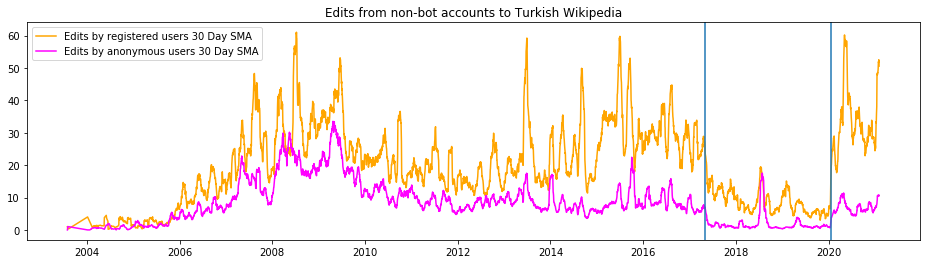

In [19]:
plt.figure(figsize=(16,4))
plt.title("Edits from non-bot accounts to Turkish Wikipedia")
rolling_mean = registered_edits['number_of_edits'].rolling('30d').mean()
plt.plot(registered_edits.index.values, rolling_mean, label='Edits by registered users 30 Day SMA', color='orange')
rolling_mean2 = anonymous_edits['number_of_edits'].rolling('30d').mean()
plt.plot(anonymous_edits.index.values, rolling_mean2, label='Edits by anonymous users 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

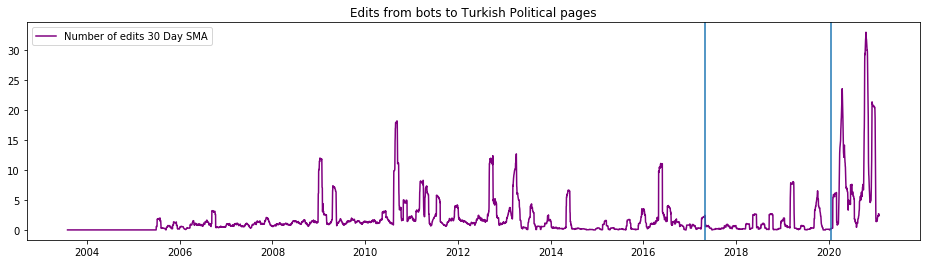

In [20]:
plt.figure(figsize=(16,4))
plt.title("Edits from bots to Turkish Political pages")
rolling_mean = bot_edits['number_of_edits'].rolling('30d').mean()
plt.plot(bot_edits.index.values, rolling_mean, label='Number of edits 30 Day SMA', color='purple')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [21]:
reverts = pd.read_csv(f'{DATA_PATH}/processed_data/df_reverts_by_pageid.csv')

In [22]:
reverts = reverts[reverts.page_id.isin(edits.page_id.unique())]

In [23]:
reverts.columns = ['date', 'page_id', 'user_kind','number_of_reverts']

In [24]:
reverts['date'] = pd.to_datetime(reverts['date'],   utc = True)

In [25]:
grouped_reverts = reverts.groupby(['date'])['number_of_reverts'].sum()

In [26]:
grouped_reverts = grouped_reverts.reset_index().set_index('date')

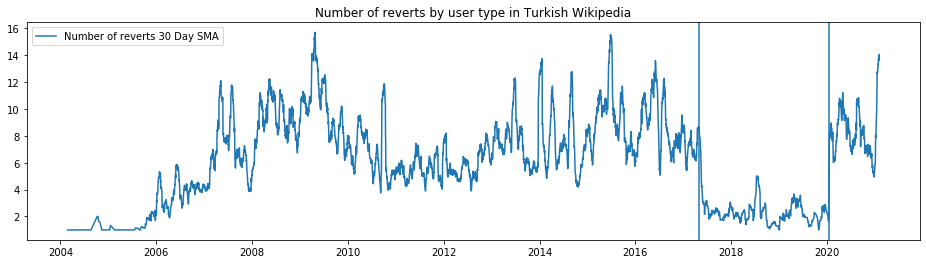

In [28]:
plt.figure(figsize=(16,4))

plt.title(f"Number of reverts by user type in Turkish Wikipedia")
rolling_mean = grouped_reverts['number_of_reverts'].rolling(window='30d').mean()
plt.plot(grouped_reverts.index.values, rolling_mean, label=f'Number of reverts 30 Day SMA')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [29]:
revert_rate = pd.merge(grouped_reverts, daily_edits[daily_edits.user_kind != 'bot'].groupby('date')[['number_of_edits']].sum(), left_index=True, right_index=True)

In [30]:
revert_rate['revert_rate'] = revert_rate['number_of_reverts']/revert_rate['number_of_edits']

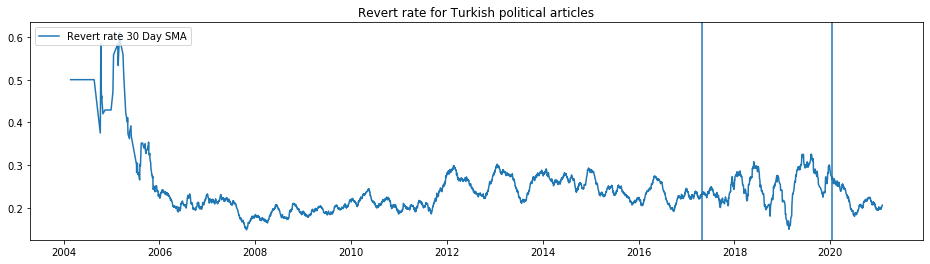

In [31]:
plt.figure(figsize=(16,4))

plt.title(f"Revert rate for Turkish political articles")
rolling_mean = revert_rate['revert_rate'].rolling(window='90d').mean()
plt.plot(revert_rate.index.values, rolling_mean, label=f'Revert rate 30 Day SMA')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [32]:
edits[edits['user_kind'] != 'bot'].groupby('page_title')['number_of_edits'].sum().sort_values(ascending = False).head(20)

page_title
Mustafa_Kemal_Atatürk            5671
Fethullah_Gülen                  5014
Ermeni_Kırımı                    4566
PKK                              4526
Ankara                           4219
Adalet_ve_Kalkınma_Partisi       4204
Recep_Tayyip_Erdoğan             4054
Hakan_Şükür                      3607
Cumhuriyet_Halk_Partisi          3443
Abdullah_Öcalan                  2268
Kuzey_Kıbrıs_Türk_Cumhuriyeti    2218
Ergenekon_(örgüt)                2125
Gezi_Parkı_olayları              2014
27_Mayıs_Darbesi                 1746
İsmet_İnönü                      1735
Alparslan_Türkeş                 1685
Adnan_Menderes                   1576
12_Eylül_Darbesi                 1502
Türkiye_Büyük_Millet_Meclisi     1481
Kemal_Kılıçdaroğlu               1399
Name: number_of_edits, dtype: int64

## Topic comparison

In [33]:
TOPICS_PATH = '/dlabdata1/turkish_wiki'
DATA_PATH = '/dlabdata1/turkish_wiki/processed_data'

In [34]:
topics_df = pd.read_csv(f"{TOPICS_PATH}/trwiki_topics.csv")

In [35]:
topics_df.pid = topics_df.pid.astype(str)

In [36]:
page_names = pd.read_csv(f"{TOPICS_PATH}/processed_data/page.csv", usecols = ['page_id', 'page_title', 'page_namespace'])

In [37]:
page_names = page_names.convert_dtypes()

In [38]:
page_names = page_names[page_names['page_namespace'] == '0']

In [39]:
topics_df = pd.merge(topics_df, page_names, left_on = 'pid', right_on = 'page_id')

In [40]:
tr_politics = pd.read_csv('tr_politics_pages.csv')

In [41]:
tr_politics.page_id = tr_politics.page_id.astype(str)

In [42]:
tr_politics = pd.merge(tr_politics, topics_df, left_on = 'page_id', right_on = 'pid')

In [45]:
food = topics_df[topics_df['Culture.Food_and_drink'] > 0.5].pid

In [46]:
middle_east_politics = topics_df[(topics_df['History_and_Society.Politics_and_government'] > 0.3) & (topics_df['Geography.Regions.Asia.West_Asia'] > 0.8)].pid